In [1]:
import json
import imgaug as ia
ia.seed(1)
# imgaug uses matplotlib backend for displaying images
%matplotlib inline
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
# imageio library will be used for image input/output
import imageio
import pandas as pd
import numpy as np
import re
import os
import glob

In [2]:
with open('result_1011.json') as f:
  data = json.load(f)

In [15]:
def convertYOLO2Other(yolo_bb: np.ndarray):
    # This function converts yolo bounding box to coordinates accpeted by imgaug library.
    # yolo_bb: a numpy array generated from the result json
    H,W = 640, 640
    if yolo_bb.size == 0: return yolo_bb
    imgaug_bb = np.zeros(yolo_bb.shape)
    if yolo_bb.ndim <= 1: 
        class_id = yolo_bb[0]
        center_x, center_y, w, h = yolo_bb[1] * W, yolo_bb[2] * H, yolo_bb[3] * W, yolo_bb[4] * H
        x1 = center_x - w / 2
        y1 = center_y - h / 2
        x2 = center_x + w / 2
        y2 = center_y + h / 2
        conf = yolo_bb[5]
        imgaug_bb = np.array([class_id, x1, y1, x2, y2, conf])
    else: 
        for n, bb in enumerate(yolo_bb):
            class_id = bb[0]
            center_x, center_y, w, h = bb[1] * W, bb[2] * H, bb[3] * W, bb[4] * H
            x1 = center_x - w / 2
            y1 = center_y - h / 2
            x2 = center_x + w / 2
            y2 = center_y + h / 2
            conf = bb[5]
            imgaug_bb[n] = np.array([class_id, x1, y1, x2, y2, conf])
    return imgaug_bb

def read_ith_pred_result_yolo(data, i, threshold=0):
    # data: the json file
    # i: the index of the json file
    # threshold: confidence threshold
    assert threshold <= 1
    filename = data[i]['filename'][15:]
    img = imageio.imread('Test/' + filename)

    # data[i] is the i-th image
    num_bbox = len(data[i]['objects'])
    pred_bbox_single_img = np.zeros([num_bbox, 6])
    for n, box in enumerate(data[i]['objects']):
        if box['confidence'] >= threshold:
            tmp = np.zeros(6)
            tmp[0] = box['class_id']
            tmp[1] = box['relative_coordinates']['center_x']
            tmp[2] = box['relative_coordinates']['center_y']
            tmp[3] = box['relative_coordinates']['width']
            tmp[4] = box['relative_coordinates']['height']
            tmp[5] = box['confidence']
            pred_bbox_single_img[n, :] = tmp
    return filename, img, pred_bbox_single_img


We have 109 testing images. Each image contains multiple predicted objects!

img-33_42.039688,-87.908496.jpg
[[1.       0.405943 0.506252 0.241572 0.212684 0.405164]
 [1.       0.944238 0.449225 0.095183 0.205341 0.323521]
 [0.       0.137852 0.554331 0.205867 0.346692 0.987298]
 [0.       0.710342 0.514436 0.214787 0.1682   0.9414  ]
 [0.       0.413247 0.496745 0.279477 0.241888 0.848989]
 [0.       0.944898 0.442671 0.102346 0.206605 0.417886]]
BoundingBoxesOnImage([BoundingBox(x1=182.5005, y1=255.9424, x2=337.1066, y2=392.0602, label=1), BoundingBox(x1=573.8538, y1=221.7949, x2=634.7709, y2=353.2131, label=1), BoundingBox(x1=22.3478, y1=243.8304, x2=154.1027, y2=465.7133, label=0), BoundingBox(x1=385.8871, y1=275.4150, x2=523.3507, y2=383.0630, label=0), BoundingBox(x1=175.0454, y1=240.5126, x2=353.9107, y2=395.3210, label=0), BoundingBox(x1=571.9840, y1=217.1958, x2=637.4854, y2=349.4230, label=0)], shape=(640, 640, 3))


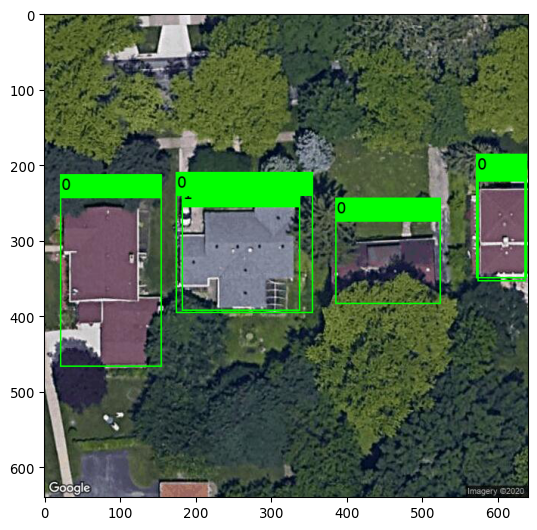

In [18]:
i = 0
num_images = len(data)
filename, img, single_image_yolo_pred = read_ith_pred_result_yolo(data, 0, 0.30)
single_image_imgaug_pred = convertYOLO2Other(single_image_yolo_pred)
imgaug_bbox_single_img = BoundingBoxesOnImage.from_xyxy_array(single_image_imgaug_pred[:, 1:5], shape=img.shape)
for n, bb in enumerate(imgaug_bbox_single_img): 
    bb.label = single_image_imgaug_pred[n, 0].astype('int')

print(filename)
print(single_image_yolo_pred)
print(imgaug_bbox_single_img)

ia.imshow(imgaug_bbox_single_img.draw_on_image(img, size=2))
imageio.imwrite("sampleImages/bbox_" + filename, imgaug_bbox_single_img.draw_on_image(img, size=2))

In [23]:
# imgaug_bbox_single_img[0].iou(imgaug_bbox_single_img[4])
def labelname(filename):
    assert len(filename) != 0
    return filename.split('.jpg')[0] + '.txt'

labelname = labelname(filename)

In [30]:
def draw_ground_truth_label(labelname, img, output_path):
    yolo_bb = np.loadtxt('Test/' + labelname)
    imgaug_bb = np.zeros(yolo_bb.shape)
    W = img.shape[0]
    H = img.shape[1]
    for n, bb in enumerate(yolo_bb):
        class_id = bb[0]
        center_x, center_y, w, h = bb[1] * W, bb[2] * H, bb[3] * W, bb[4] * H
        x1 = center_x - w / 2
        y1 = center_y - h / 2
        x2 = center_x + w / 2
        y2 = center_y + h / 2
        imgaug_bb[n] = np.array([class_id, x1, y1, x2, y2])
        
    gt = BoundingBoxesOnImage.from_xyxy_array(imgaug_bb[:, 1:], shape=img.shape)

    for n, bb in enumerate(gt): 
        bb.label = imgaug_bb[n, 0].astype('int')
    ia.imshow(gt.draw_on_image(img, size=2))
    imageio.imwrite(output_path, gt.draw_on_image(img, size=2))

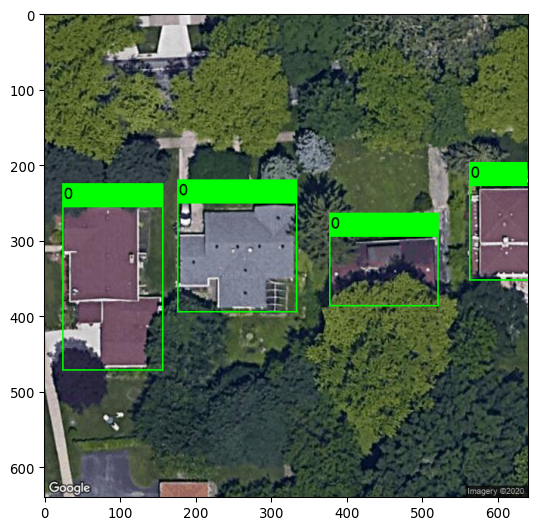

In [32]:
draw_ground_truth_label(labelname, img, 'Test/gt' + filename)